<a href="https://colab.research.google.com/github/rockey1006/Variational-Autoencoders/blob/master/LDF%2BVAE2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [70]:
from time import time
import logging
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC


print(__doc__)

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')


# #############################################################################
# Download the data, if not already on disk and load it as numpy arrays

lfw_people = fetch_lfw_people(min_faces_per_person=0, resize=0.5)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)


# #############################################################################
# Split into a training set and a test set using a stratified k fold

# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)



Automatically created module for IPython interactive environment
Total dataset size:
n_samples: 13233
n_features: 2914
n_classes: 5749


In [0]:
x_train = X_train.astype('float32') / 255.#数据预处理归一化


In [0]:
x_test = X_test.astype('float32') / 255.#数据预处理归一化


In [68]:
len(X_train)

9924

In [67]:
len(X_test)

3309

In [0]:
len(y_train)

In [73]:
X_train[0].shape


(2914,)

In [0]:
print(X_train[0])

In [0]:
batch_size = 1
original_dim = 2914
latent_dim = 2
intermediate_dim = 256
epochs = 10
epsilon_std = 1.0
x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)#
z_mean = Dense(latent_dim)(h)#
z_log_var = Dense(latent_dim)(h)#

In [90]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])#输入是z_mean和z_log_var，输出是z
decoder_h = Dense(intermediate_dim, activation='relu')#隐藏层
decoder_mean = Dense(original_dim, activation='sigmoid')#输出层
h_decoded = decoder_h(z)#中间值
x_decoded_mean = decoder_mean(h_decoded)#输出值
vae = Model(x, x_decoded_mean)
#model = Model(inputs=[a1, a2], outputs=[b1, b3, b3])

# Compute VAE loss
xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) #KL+交叉熵
vae_loss = K.mean(xent_loss + kl_loss)

vae.add_loss(vae_loss) #复杂损失函数所以不在compile声明，而使用add_loss
vae.compile(optimizer='rmsprop') #用于配置训练模型。

#compile(self, optimizer, loss, metrics=None, loss_weights=None, sample_weight_mode=None, 
#weighted_metrics=None, target_tensors=None)

vae.summary()

Model: "model_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           (None, 2914)         0                                            
__________________________________________________________________________________________________
dense_46 (Dense)                (None, 256)          746240      input_14[0][0]                   
__________________________________________________________________________________________________
dense_47 (Dense)                (None, 2)            514         dense_46[0][0]                   
__________________________________________________________________________________________________
dense_48 (Dense)                (None, 2)            514         dense_46[0][0]                   
___________________________________________________________________________________________

In [91]:
vae.fit(x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        verbose=2,
        validation_data=(x_test, None))

Train on 9924 samples, validate on 3309 samples
Epoch 1/10
 - 128s - loss: 1948.4859 - val_loss: 1928.3273
Epoch 2/10
 - 124s - loss: 1929.3481 - val_loss: 1926.0417
Epoch 3/10
 - 126s - loss: 1927.7004 - val_loss: 1930.5256
Epoch 4/10
 - 124s - loss: 1926.9418 - val_loss: 1925.2136
Epoch 5/10
 - 125s - loss: 1926.4537 - val_loss: 1925.2618
Epoch 6/10
 - 124s - loss: 1926.1292 - val_loss: 1923.8818
Epoch 7/10
 - 125s - loss: 1925.7585 - val_loss: 1925.3172
Epoch 8/10
 - 122s - loss: 1925.4765 - val_loss: 1924.2760
Epoch 9/10
 - 123s - loss: 1925.2062 - val_loss: 1923.8772
Epoch 10/10
 - 127s - loss: 1925.0532 - val_loss: 1924.2772


In [0]:
encoder = Model(x, z_mean)
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)

In [93]:
plt.figure(figsize=(18, 16), dpi=200)#Create a new figure.


<Figure size 3600x3200 with 0 Axes>

<Figure size 3600x3200 with 0 Axes>

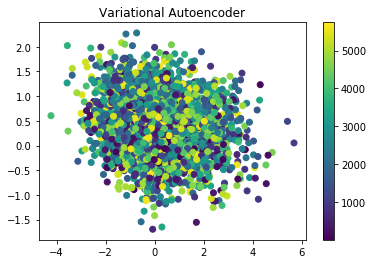

In [94]:
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1],c=y_test)
plt.title('Variational Autoencoder')
plt.colorbar()
plt.show()
##13233 images
#5749 people
#

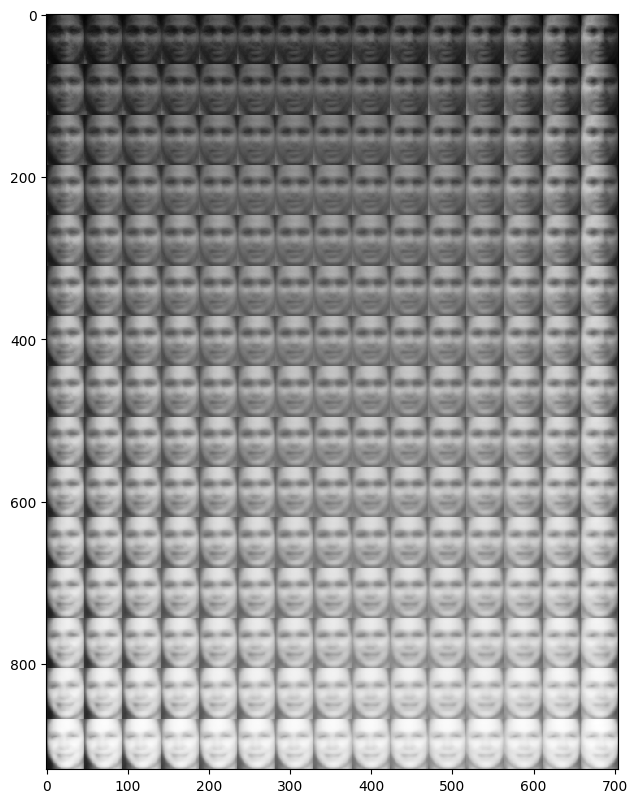

In [95]:
# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 62
size = 47
figure = np.zeros((digit_size * n, size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * size: (j + 1) * size] = digit

plt.figure(figsize=(10, 10), dpi=100)
plt.imshow(figure, cmap='Greys_r')
plt.show()